<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew.

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [22]:
# ANSWER
titanic_csv = 'titanic_train.csv'

In [23]:
df = pd.read_csv(titanic_csv)

In [24]:
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Why would we want to set an index column based on `PassengerId`?

In [25]:
df.set_index('PassengerId', inplace=True)

In [26]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values.

In [27]:
# ANSWER
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Lets Clean up the data - Cabin

In [30]:
df['Cabin'].unique()

array([np.str_('E58'), 'C85', np.str_('D11'), 'C123', np.str_('B94'),
       np.str_('C54'), 'E46', np.str_('E101'), np.str_('D50'),
       np.str_('D45'), 'G6', 'C103', np.str_('B78'), np.str_('D36'),
       np.str_('B22'), np.str_('C91'), np.str_('E121'), np.str_('C111'),
       np.str_('B39'), 'D56', 'A6', np.str_('B49'), np.str_('D15'),
       np.str_('C104'), 'C23 C25 C27', np.str_('B71'), np.str_('B77'),
       np.str_('C83'), np.str_('E50'), np.str_('C110'), np.str_('D26'),
       np.str_('A31'), np.str_('D47'), np.str_('C30'), np.str_('C49'),
       np.str_('D7'), np.str_('D30'), np.str_('C22 C26'), np.str_('C99'),
       np.str_('A24'), np.str_('E49'), np.str_('E77'), np.str_('E68'),
       np.str_('C62 C64'), 'D33', np.str_('E10'), 'B30', 'C52',
       np.str_('E17'), np.str_('B57 B59 B63 B66'), np.str_('D10 D12'),
       'B28', np.str_('E8'), np.str_('F G73'), 'F33', np.str_('A19'),
       np.str_('B101'), np.str_('C93'), np.str_('A14'), np.str_('T'),
       np.str_('C101'),

In [31]:
replacement_values = np.array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30',
       'E121', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 B84', 'D17', 'A36',
       'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42',
       'C148']) # create numpy.ndarray list
def replace_nan_with_random_choice(x):
    if pd.isna(x):
        return np.random.choice(replacement_values)
    return x

## then call on a particular column of a Dataframe
df['Cabin'] = df['Cabin'].apply(replace_nan_with_random_choice)

In [32]:
## Check if Cabin is fixed
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Now clean the Age

In [35]:
ages = df['Age'].unique()
ages = ages[~np.isnan(ages)] ## remove NULL
percentiles = np.percentile(ages, [25, 50, 75])
print(percentiles)
replacement_age = np.array(percentiles)
def replace_nan_with_random_choice_age(x):
    if pd.isna(x):
        return np.random.choice(replacement_age)
    return x

## then call on a particular column of a Dataframe
df['Age'] = df['Age'].apply(replace_nan_with_random_choice_age)

[16.75 32.75 50.25]


In [37]:
df.info()
## All Cleaned up

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [41]:
features = ['Pclass', 'Parch']
target = 'Survived'

X = df[features]
y = df[target]



#### 3.2 Split

Split the data into training and testing subsets:

- Use `random_state` = 1

In [42]:
# ANSWER
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [45]:
# ANSWER
# Create Model
# Train the logistic regression model
model = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [46]:
# ANSWER
# Fit Model
model.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [50]:
# ANSWER
coef_var = model.coef_[0]
print(coef_var)

[-0.90823438  0.33425289]


The computed intercept (`intercept_`) is the 1st element of another array:

In [52]:
# ANSWER
intercept_var = model.intercept_[0]
print(intercept_var)

1.4083463518414236


We can create tuples of the predictor names and coefficients like this:

In [53]:
# ANSWER
print(set(zip(features, model.coef_[0])))

{('Parch', np.float64(0.33425288789154306)), ('Pclass', np.float64(-0.908234376269532))}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [54]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.908234
Parch       +0.334253


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The accuracy `score` is the proportion of correct predictions:

In [55]:
# ANSWER
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

accuracy, precision, recall

(0.6536312849162011,
 np.float64(0.6122448979591837),
 np.float64(0.410958904109589))

What is the accuracy `score` for the test data?

In [56]:
# ANSWER
print(accuracy)

0.6536312849162011


What can we say about this result?

ANSWER
Results Interpretation
Accuracy: 0.6536 (or 65.36%)

Definition: Accuracy is the proportion of correctly classified instances (both true positives and true negatives) out of the total instances.
Interpretation: The model correctly predicts survival for 65.36% of the passengers. This means that the model's overall performance is somewhat better than random guessing but leaves room for improvement.
Precision: 0.6122 (or 61.22%)

Definition: Precision is the proportion of true positive predictions out of all positive predictions (true positives + false positives). It measures the accuracy of the positive predictions made by the model.
Interpretation: Of all the passengers the model predicted would survive, 61.22% actually survived. This indicates that the model has a moderate level of precision, but there is a significant proportion of false positives.
Recall: 0.4110 (or 41.10%)

Definition: Recall (also known as sensitivity or true positive rate) is the proportion of true positive predictions out of all actual positives (true positives + false negatives). It measures the model's ability to identify all relevant instances.
Interpretation: The model correctly identifies 41.10% of the passengers who actually survived. This indicates that the model has a relatively low ability to capture all the true positive cases, missing out on a significant number of actual survivors (high false negative rate).
Summary of Results
Accuracy (65.36%): The model's overall performance is better than random guessing, but not by a large margin.
Precision (61.22%): The model's positive predictions (predicted survivors) are moderately accurate, but there are many false positives (people predicted to survive who did not).
Recall (41.10%): The model has a low sensitivity to actual survivors, missing many true positives.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [57]:
# ANSWER
features = ['Pclass', 'Parch','Age']
target = 'Survived'

X = df[features]
y = df[target]

In [73]:
# Build Model


# Fit Model

# Score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

accuracy, precision, recall

(0.659217877094972,
 np.float64(0.6153846153846154),
 np.float64(0.4383561643835616))

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

Accuracy (75.42%): The model's overall performance has improved significantly with the addition of the 'Age' feature.

Precision (77.78%): The model's positive predictions (predicted survivors) are more accurate, with a higher percentage of true survivors among the predicted survivors.

Recall (56.76%): The model is now better at identifying actual survivors, although there is still room for improvement in capturing all true positives.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [74]:
# ANSWER
logreg = LogisticRegression()
logreg.fit(X_test ,y_test)
y_pred_class = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred_class))

[[89 17]
 [41 32]]


Nb. Here is how `confusion_matrix` arranges its output:

In [67]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

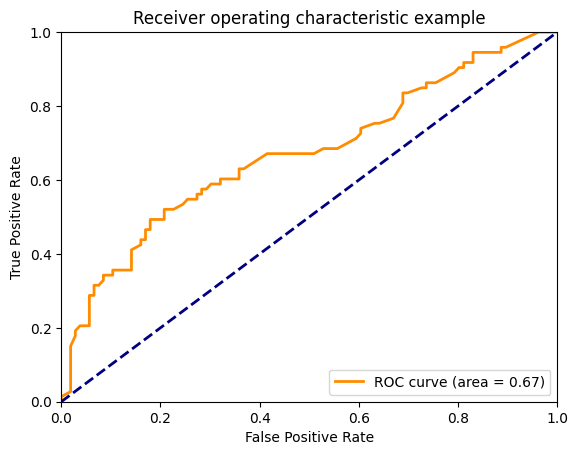

In [76]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict


from sklearn import metrics

preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [87]:
df_new = pd.read_csv(titanic_csv)


In [88]:
replacement_values = np.array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64', 'E24', 'C90', 'C45', 'E8', 'B101', 'D45', 'C46', 'D30',
       'E121', 'D11', 'E77', 'F38', 'B3', 'D6', 'B82 B84', 'D17', 'A36',
       'B102', 'B69', 'E49', 'C47', 'D28', 'E17', 'A24', 'C50', 'B42',
       'C148']) # create numpy.ndarray list
def replace_nan_with_random_choice(x):
    if pd.isna(x):
        return np.random.choice(replacement_values)
    return x

## then call on a particular column of a Dataframe
df_new['Cabin'] = df_new['Cabin'].apply(replace_nan_with_random_choice)

In [90]:
titanic_with_dummies = pd.get_dummies(data = df_new, columns = ['Sex', 'Embarked', 'Pclass'],
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,D47,False,True,False,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B5,True,False,False,False,True,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True,True,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,False,True,False,False,True,False,False,True


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first variable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [91]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

In [92]:
titanic_with_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,D47,False,True,False,False,True,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,True,False,True,False,False,True,False,False
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B5,True,False,False,False,True,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,True,False,False,False,True,True,False,False
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,False,True,False,False,True,False,False,True


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [93]:
titanic_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Name         891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Cabin        891 non-null    object 
 9   Sex_female   891 non-null    bool   
 10  Sex_male     891 non-null    bool   
 11  Embarked_C   891 non-null    bool   
 12  Embarked_Q   891 non-null    bool   
 13  Embarked_S   891 non-null    bool   
 14  Pclass_1     891 non-null    bool   
 15  Pclass_2     891 non-null    bool   
 16  Pclass_3     891 non-null    bool   
dtypes: bool(8), float64(2), int64(4), object(3)
memory usage: 69.7+ KB


In [99]:
titanic_with_dummies.shape

(891, 17)

In [103]:
# ANSWER
# Set Feature Both Numerical, Categorical


features_new = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3' ]
target_new = 'Survived'

X = titanic_with_dummies[features_new]
y = titanic_with_dummies[target_new]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

accuracy, precision, recall

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.7821229050279329,
 np.float64(0.7575757575757576),
 np.float64(0.684931506849315))

Plot the ROC curve for the new model:

[[89 17]
 [23 50]]


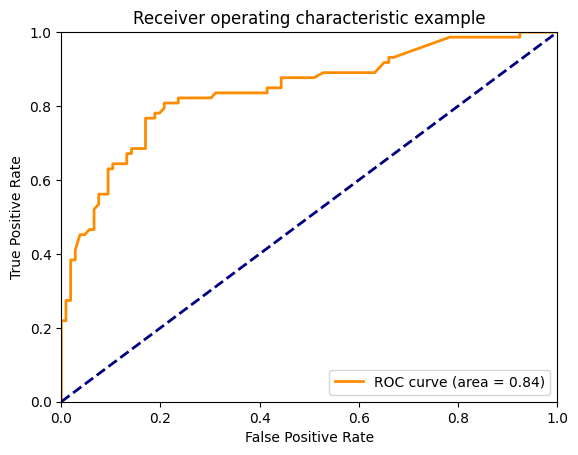

In [104]:
# ANSWER
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_test ,y_test)
y_pred_class = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred_class))

preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with this metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [116]:
# ANSWER

#Lets create a function

def model_calc(X, Y, n):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=n)

    # Train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Fit the logistic regression model again for ROC curve
    logreg = LogisticRegression()
    logreg.fit(X_test, y_test)
    y_pred_class = logreg.predict(X_test)

    # Print confusion matrix
    print(confusion_matrix(y_test, y_pred_class))

    # Predict probabilities
    preds = logreg.predict_proba(X_test)[:,1]

    # Store the false positive rate (fpr), true positive rate (tpr), and roc_auc
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, fpr, tpr, roc_auc

def plot_ruc_curve(fpr, tpr, roc_auc):
    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [123]:
Features_set_1 = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3' ]
Features_set_2 = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3','Fare' ]
Features_set_3 = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3','Cabin', 'Fare' ] ## Didn't work
Features_set_4 = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3','Ticket']  ## Didn't work
Features_set_all = ['Parch','Age', 'Sex_male', 'Sex_female', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1','Pclass_2','Pclass_3','SibSp' ,'Ticket' , 'Cabin', 'Fare' ]  ## Didn't work
target_new = 'Survived'

Y = titanic_with_dummies[target_new]

In [124]:

X = titanic_with_dummies[Features_set_1]
accuracy, precision, recall, fpr, tpr, roc_auc = model_calc(X,Y,42)
print(accuracy, precision, recall)

X = titanic_with_dummies[Features_set_2]
accuracy, precision, recall, fpr, tpr, roc_auc = model_calc(X,Y,42)
print(accuracy, precision, recall)



[[91 14]
 [13 61]]
0.8044692737430168 0.782608695652174 0.7297297297297297
[[91 14]
 [13 61]]
0.7988826815642458 0.7794117647058824 0.7162162162162162


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Cross Validation

In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

def cross_validation_scores_classification(X, Y, k_folds=5):
    """
    Perform K-Fold cross-validation and return a DataFrame of train and test scores for classification metrics.
    Parameters:
    X (pd.DataFrame): Features.
    Y (pd.Series): Target variable.
    k_folds (int): Number of folds for K-Fold cross-validation.
    Returns:
    pd.DataFrame: DataFrame containing the train and test scores for each fold.
    """
    # Set up K-Fold cross-validation
    k_fold = KFold(k_folds, shuffle=True, random_state=42)
    train_accuracy = []
    train_precision = []
    train_recall = []
    test_accuracy = []
    test_precision = []
    test_recall = []

    # Perform cross-validation
    for train_idx, test_idx in k_fold.split(X):
        # Get training and test sets for X and y
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

        # Create and fit the Logistic Regression model
        model = LogisticRegression()
        model.fit(X_train, Y_train)

        # Make predictions on training and test sets
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        # Calculate accuracy, precision, and recall for training set
        train_accuracy_val = accuracy_score(Y_train, Y_train_pred)
        train_precision_val = precision_score(Y_train, Y_train_pred)
        train_recall_val = recall_score(Y_train, Y_train_pred)
        train_accuracy.append(train_accuracy_val)
        train_precision.append(train_precision_val)
        train_recall.append(train_recall_val)

        # Calculate accuracy, precision, and recall for test set
        test_accuracy_val = accuracy_score(Y_test, Y_test_pred)
        test_precision_val = precision_score(Y_test, Y_test_pred)
        test_recall_val = recall_score(Y_test, Y_test_pred)
        test_accuracy.append(test_accuracy_val)
        test_precision.append(test_precision_val)
        test_recall.append(test_recall_val)

    # Create a DataFrame to display the metrics
    metrics_df = pd.DataFrame({
        'Fold': range(1, k_folds + 1),
        'Train Accuracy': train_accuracy,
        'Train Precision': train_precision,
        'Train Recall': train_recall,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall
    })

    return metrics_df




In [132]:


X = titanic_with_dummies[Features_set_2]
Y = titanic_with_dummies[target_new]
metrics_df = cross_validation_scores_classification(X, Y, k_folds=5)
print(metrics_df)

   Fold  Train Accuracy  Train Precision  Train Recall  Test Accuracy  \
0     1        0.797753         0.754098      0.686567       0.798883   
1     2        0.805049         0.767717      0.709091       0.780899   
2     3        0.786816         0.736220      0.687500       0.831461   
3     4        0.814867         0.779070      0.728261       0.735955   
4     5        0.793829         0.751938      0.700361       0.820225   

   Test Precision  Test Recall  
0        0.779412     0.716216  
1        0.759259     0.611940  
2        0.803030     0.757143  
3        0.661017     0.590909  
4        0.753846     0.753846  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



